In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB3'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[2]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (~((x[:,0] > 7500) & (x[:,0] < 7600))) & \
          (x[:,0] > 3600) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

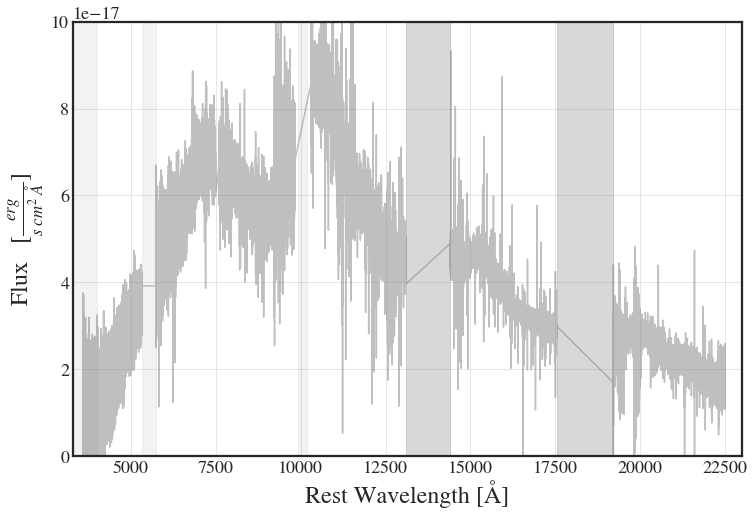

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 1e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [6]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, 
                    v_out_n=0.2, v_phot_n=0.1, tau_n=0.2, lambda_n=7500, ve_n=0.1
                   
                   ): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)

    pcyg_prof_n = p_cygni_line_corr(wav, v_out_n, v_phot_n, tau_n   , lambda_n, vref=vref, ve=ve_n , t0=t0)

    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction * pcyg_prof_n
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2 = v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    v_out_n, v_phot_n, tau_n, lambda_n, ve_n = v["v_out_n"], v["v_phot_n"], v["tau_n"], v["lambda_n"], v["ve_n"]
    
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, 
                           v_out_n=v_out_n, v_phot_n=v_phot_n, tau_n=tau_n, lambda_n=lambda_n, ve_n=ve_n)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [7]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [10]:
p = lmfit.Parameters()
OB = 'OB4_760Pcygni'
with open("./data/OB3_760Pcygni_init.json", 'r') as infile:
    p.load(infile)

start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 1.1904333591461183


In [12]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=3.4), #p['ve'], p['vphot']


(42.462451286432206,)

In [13]:
lum_dist_arr(mi2.params['N'],mi2.params['v_phot_n'],n_days=3.4), #p['ve'], p['vphot']


(41.21929033804283,)

In [14]:
mi2.params

name,value,initial value,min,max,vary
T,3415.40289,3394,2500.00000,7500.00000,True
N,3.7051e-29,3.8e-29,-inf,inf,True
vphot,0.21119858,0.204,0.00000000,1.00000000,True
vmax,0.24181507,0.233,0.00000000,1.00000000,True
t0,298800.000,298800,-inf,inf,False
tau,1.58993903,1.6,0.00000000,10.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,6.61836989,6.6,0.00000000,20.0000000,True
occult,3.64624021,3.5,0.10000000,20.0000000,True
amp1,0.96822007,0.96,0.01000000,5.00000000,True


In [15]:
with open("./data/%s_3.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [25]:
p = lmfit.Parameters()
with open("./Data/%s_3.json"%OB, 'r') as infile:
    p.load(infile)

p['lambda_n'].value = 7500
p['lambda_n'].vary  = False
#p
#lum_dist_arr(p['N'],p['vphot'],n_days=1.45), p['ve'], p['vphot']

# OB1_1 : free ve
# OB1_2 : free ve
# OB1_3 : fixed ve [0,0.1]
p

name,value,initial value,min,max,vary
T,3415.40289,3394,2500.00000,7500.00000,True
N,3.7051e-29,3.8e-29,-inf,inf,True
vphot,0.21119858,0.204,0.00000000,1.00000000,True
vmax,0.24181507,0.233,0.00000000,1.00000000,True
t0,298800.000,298800,-inf,inf,False
tau,1.58993903,1.6,0.00000000,10.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,6.61836989,6.6,0.00000000,20.0000000,True
occult,3.64624021,3.5,0.10000000,20.0000000,True
amp1,0.96822007,0.96,0.01000000,5.00000000,True


In [35]:
#p = lmfit.Parameters()
#OB = 'OB4_760Pcygni'
##with open("./data/%s_init.json"%OB, 'r') as infile:
 #   p.load(infile)

In [35]:
pickle_in = open("./data/OB3/OB3_two_Pcygni_28x2000_lambda0_7500.pkl","rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params


name,value,standard error,relative error,initial value,min,max,vary
T,3408.53281,2.40298065,(0.07%),3415.4028853683353,2500.00000,7500.00000,True
N,3.7177e-29,9.9336e-32,(0.27%),3.705093416020356e-29,-inf,inf,True
vphot,0.20525150,0.00232741,(1.13%),0.21119858450110202,0.00000000,1.00000000,True
vmax,0.23819309,0.00125663,(0.53%),0.24181506946147507,0.00000000,1.00000000,True
t0,298800.000,,(0.53%),298800,-inf,inf,False
tau,1.42964450,0.06237798,(4.36%),1.5899390307967098,0.00000000,10.0000000,True
vref,0.00000000,,(4.36%),0.0,0.00000000,1.00000000,False
ve,4.65219162,1.22378904,(26.31%),6.618369888440105,0.00000000,20.0000000,True
occult,3.76508535,0.08127279,(2.16%),3.6462402124016253,0.10000000,20.0000000,True
amp1,0.98392952,0.00749772,(0.76%),0.9682200714954927,0.01000000,5.00000000,True


In [36]:
pickle_in = open("./data/OB3/OB3_two_Pcygni_28x2000_lambda0_7500.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['cen1'].vary=True; p['cen2'].vary=True; 
p['cen1'].value=1.529e-6; p['cen2'].value=1.98e-6; 

p['sig1'].vary=True; p['sig2'].vary=True; 
p['sig1'].value=6.26e-8; p['sig2'].value=1.44e-7; 

#p['lambda_n'].min = 6500
#p['lambda_n'].value = 7500
p['lambda_n'].vary  = False
len(p)

p['v_phot_n'].min = 0.01
p

name,value,standard error,relative error,initial value,min,max,vary
T,3408.53281,2.40298065,(0.07%),3415.4028853683353,2500.00000,7500.00000,True
N,3.7177e-29,9.9336e-32,(0.27%),3.705093416020356e-29,-inf,inf,True
vphot,0.20525150,0.00232741,(1.13%),0.21119858450110202,0.00000000,1.00000000,True
vmax,0.23819309,0.00125663,(0.53%),0.24181506946147507,0.00000000,1.00000000,True
t0,298800.000,,(0.53%),298800,-inf,inf,False
tau,1.42964450,0.06237798,(4.36%),1.5899390307967098,0.00000000,10.0000000,True
vref,0.00000000,,(4.36%),0.0,0.00000000,1.00000000,False
ve,4.65219162,1.22378904,(26.31%),6.618369888440105,0.00000000,20.0000000,True
occult,3.76508535,0.08127279,(2.16%),3.6462402124016253,0.10000000,20.0000000,True
amp1,0.98392952,0.00749772,(0.76%),0.9682200714954927,0.01000000,5.00000000,True


#### Markov Chain Monto Carlo to sample distribution


In [38]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 40 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )#wqeaaaaaaas

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 2000/2000 [1:26:17<00:00,  2.59s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 17 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [288.27777614 289.67106458 270.18923318  73.54316718 277.79993866
 215.46076718 280.72652588 290.62634201 288.71424006 264.72118493
 265.81919967 167.48671993 291.32602659 276.46354783 229.18001177
 244.27443062 173.42456846]
Time elapsed [hours]: 1.4390541093879277


In [24]:
params = [3.42091236e+03, 3.56710878e-29, 1.96550780e-01, 2.36297051e-01,
 9.28192303e-01, 6.48834520e+00, 4.27016296e+00, 1.17019455e+00,
 9.13375531e-01, 1.52800929e-06, 1.96531431e-06, 6.20840385e-08,
 1.69426627e-07, 3.04868090e-01, 4.24142272e-04, 5.52949499e-02,
 6.85780625e+03, 3.12024399e+00]
params

[3420.91236,
 3.56710878e-29,
 0.19655078,
 0.236297051,
 0.928192303,
 6.4883452,
 4.27016296,
 1.17019455,
 0.913375531,
 1.52800929e-06,
 1.96531431e-06,
 6.20840385e-08,
 1.69426627e-07,
 0.30486809,
 0.000424142272,
 0.0552949499,
 6857.80625,
 3.12024399]

In [32]:
p2 = p 
idx = 0
for i in p: 
    if p[str(i)].vary == True: 
        #print(p[str(i)])
        p2[str(i)].value = params[idx]#[name
        idx += 1
p2

name,value,standard error,relative error,initial value,min,max,vary
T,3420.91236,2.40298065,(0.07%),3415.4028853683353,2500.00000,7500.00000,True
N,3.5671e-29,9.9336e-32,(0.28%),3.705093416020356e-29,-inf,inf,True
vphot,0.19655078,0.00232741,(1.18%),0.21119858450110202,0.00000000,1.00000000,True
vmax,0.23629705,0.00125663,(0.53%),0.24181506946147507,0.00000000,1.00000000,True
t0,298800.000,,(0.53%),298800,-inf,inf,False
tau,0.92819230,0.06237798,(6.72%),1.5899390307967098,0.00000000,10.0000000,True
vref,0.00000000,,(6.72%),0.0,0.00000000,1.00000000,False
ve,6.48834520,1.22378904,(18.86%),6.618369888440105,0.00000000,20.0000000,True
occult,4.27016296,0.08127279,(1.90%),3.6462402124016253,0.10000000,20.0000000,True
amp1,1.17019455,0.00749772,(0.64%),0.9682200714954927,0.01000000,5.00000000,True


In [33]:
res2.flatchain

NameError: name 'res2' is not defined

41.04045826933586 40.69218556332744 41.40054577125484
31.485558718553257 30.50954414536995 32.70224389258663


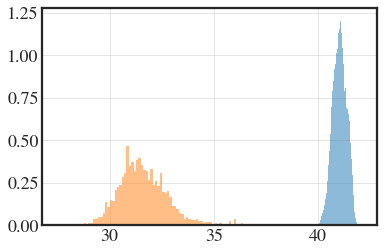

In [43]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=3.4) #* np.sqrt(np.pi)
dl = dl*np.random.uniform(low=1.427, high=1.433, size=len(dl))/1.43
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 
#nwalkers = 22
steady = int(60000)
#dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=4.4) #* np.sqrt(np.pi)
dl = lum_dist_arr( flat['N'][steady:], flat['v_phot_n'][steady:], n_days=3.4) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [44]:
with open("./Data/OB3/OB3_two_Pcygni_40x2000.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 

In [21]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3409.33177,1.20261746,(0.04%),3415.4028853683353,2500.00000,7500.00000,True
N,3.7186e-29,7.0776e-32,(0.19%),3.705093416020356e-29,-inf,inf,True
vphot,0.19985205,4.4032e-04,(0.22%),0.21119858450110202,0.00000000,1.00000000,True
vmax,0.23308412,2.9807e-04,(0.13%),0.24181506946147507,0.00000000,1.00000000,True
t0,298800.000,,(0.13%),298800,-inf,inf,False
tau,1.38067516,0.08402359,(6.09%),1.5899390307967098,0.00000000,10.0000000,True
vref,0.00000000,,(6.09%),0.0,0.00000000,1.00000000,False
ve,3.21684110,2.52622124,(78.53%),6.618369888440105,0.00000000,20.0000000,True
occult,3.79876703,0.04182808,(1.10%),3.6462402124016253,0.10000000,20.0000000,True
amp1,0.97877036,0.00715391,(0.73%),0.9682200714954927,0.01000000,5.00000000,True


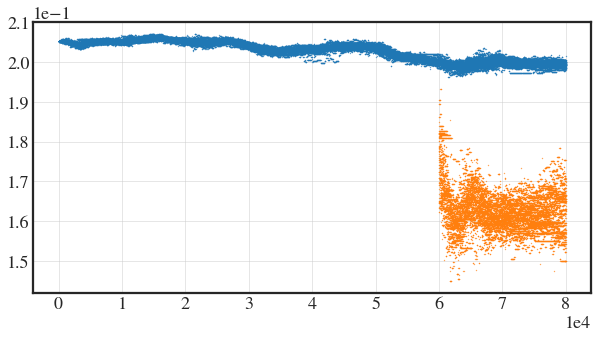

In [42]:
flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=1 ) 
plt.scatter( np.arange(len(flat['vphot']))[60000:], flat['v_phot_n'][60000:], s=0.1, alpha=1 ) 

#plt.ylim(0.1, 0.2)

In [41]:
len(flat['v_phot_n'])

80000

7047.0981500104745

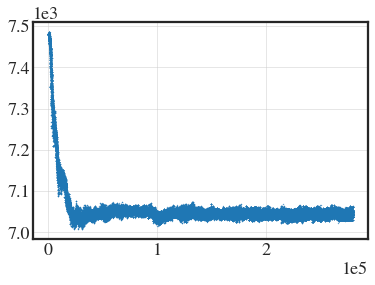

In [23]:
plt.scatter( np.arange(len(flat['vphot'])), flat['lambda_n'], s=0.1, alpha=1 ) 
np.median(flat['lambda_n'])

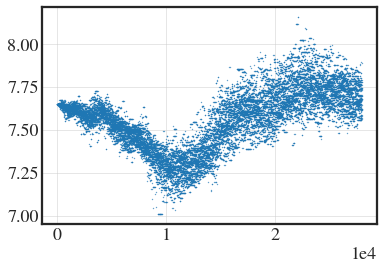

In [50]:
plt.scatter( np.arange(len(flat['vphot'])), flat['occult'], s=0.1, alpha=1 ) 


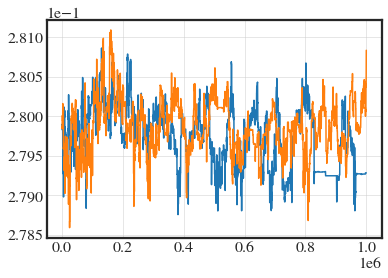

In [22]:
plt.plot( flat['vphot'][::nwalkers] ) 
plt.plot( flat['vphot'][1::nwalkers] ) 


#with open("./Data/OB1/OB1_3_peaks_filtered.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [28]:
0.0004/0.28, 0.0006/0.25

(0.0014285714285714286, 0.0024)

In [26]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,5435.97066,1.09916550,(0.02%),5447.667793298019,2500.00000,7500.00000,True
N,1.3394e-29,1.3330e-32,(0.10%),1.323796510482438e-29,-inf,inf,True
vphot,0.27990259,4.0123e-04,(0.14%),0.27748049315364803,0.00000000,1.00000000,True
vmax,0.33903818,3.3257e-04,(0.10%),0.33866506716242817,0.00000000,1.00000000,True
t0,126000.000,,(0.10%),126000,-inf,inf,False
tau,1.81124954,0.41009785,(22.64%),2.226553928678608,0.00000000,100.000000,True
vref,0.00000000,,(22.64%),0.0,0.00000000,1.00000000,False
ve,0.29258850,0.06297440,(21.52%),0.22889163223768488,0.00000000,1.00000000,True
occult,0.03624629,0.01576708,(43.50%),0.0035476731178831224,0.00000000,2.00000000,True
amp1,0.28039628,0.00358562,(1.28%),0.2567428720093393,0.01000000,5.00000000,True


In [24]:
#with open("./Data/OB1/OB1_3_peaks_XL_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

##### Plot d_l

In [7]:
pickle_in = open("./data/OB3/OB3_3_peaks_filtered_3.pkl","rb")
res2 = pickle.load(pickle_in)
#p = res2.params
#lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot']
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3394.80900,1.25253566,(0.04%),3390.270144761756,2500.00000,7500.00000,True
N,3.8173e-29,7.8046e-32,(0.20%),3.8493246810314974e-29,-inf,inf,True
vphot,0.20397601,2.2933e-04,(0.11%),0.2040010008479577,0.00000000,1.00000000,True
vmax,0.23304477,2.5878e-04,(0.11%),0.2329850979840376,0.00000000,1.00000000,True
t0,298800.000,,(0.11%),298800,-inf,inf,False
tau,1.67240336,0.02510785,(1.50%),1.7747685783730323,0.00000000,10.0000000,True
vref,0.00000000,,(1.50%),0.0,0.00000000,1.00000000,False
ve,6.62649679,2.31869019,(34.99%),5.381064797380073,0.00000000,10.0000000,True
occult,3.52827574,0.02885411,(0.82%),3.395607548961336,0.10000000,10.0000000,True
amp1,0.96920417,0.00502653,(0.52%),0.9553955107951806,0.01000000,5.00000000,True


50.60926299571685 50.339092300158505 50.85650833685412
42.77019635415807 42.379796214348126 43.195531358011806


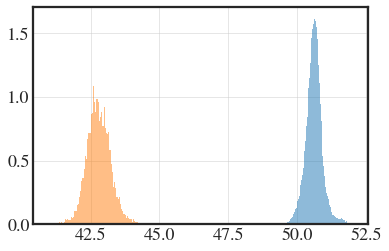

In [102]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=4.4) #* np.sqrt(np.pi)
dl = dl*np.random.uniform(low=1.427, high=1.433, size=len(dl))/1.43
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 
#nwalkers = 22
steady = int(100*nwalkers)
#dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=4.4) #* np.sqrt(np.pi)
dl = lum_dist_arr( flat['N'][steady:], flat['v_phot_n'][steady:], n_days=4.4) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

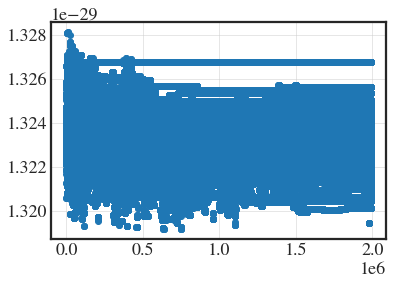

In [28]:
plt.scatter(np.arange(len(flat['vphot'][10000:])), flat['N'][10000:])


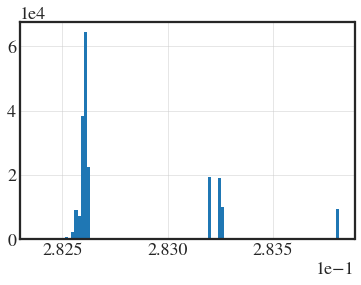

In [18]:
plt.hist(flat['vphot'][10000:], bins=100); 

In [199]:
0.00980*c*1e-3/45.7, 0.00980*c*1e-3/46.1

(64.33260393873086, 63.77440347071583)

In [17]:
import corner

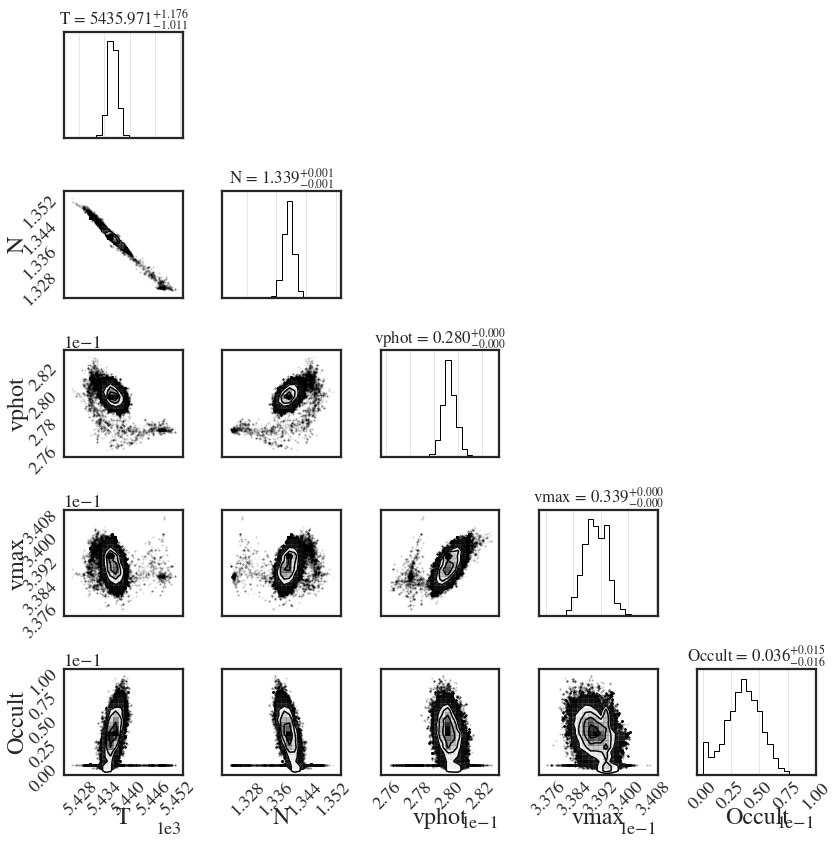

In [18]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult']]).T, 
            labels=['T', 'N', 'vphot','vmax', 'Occult'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

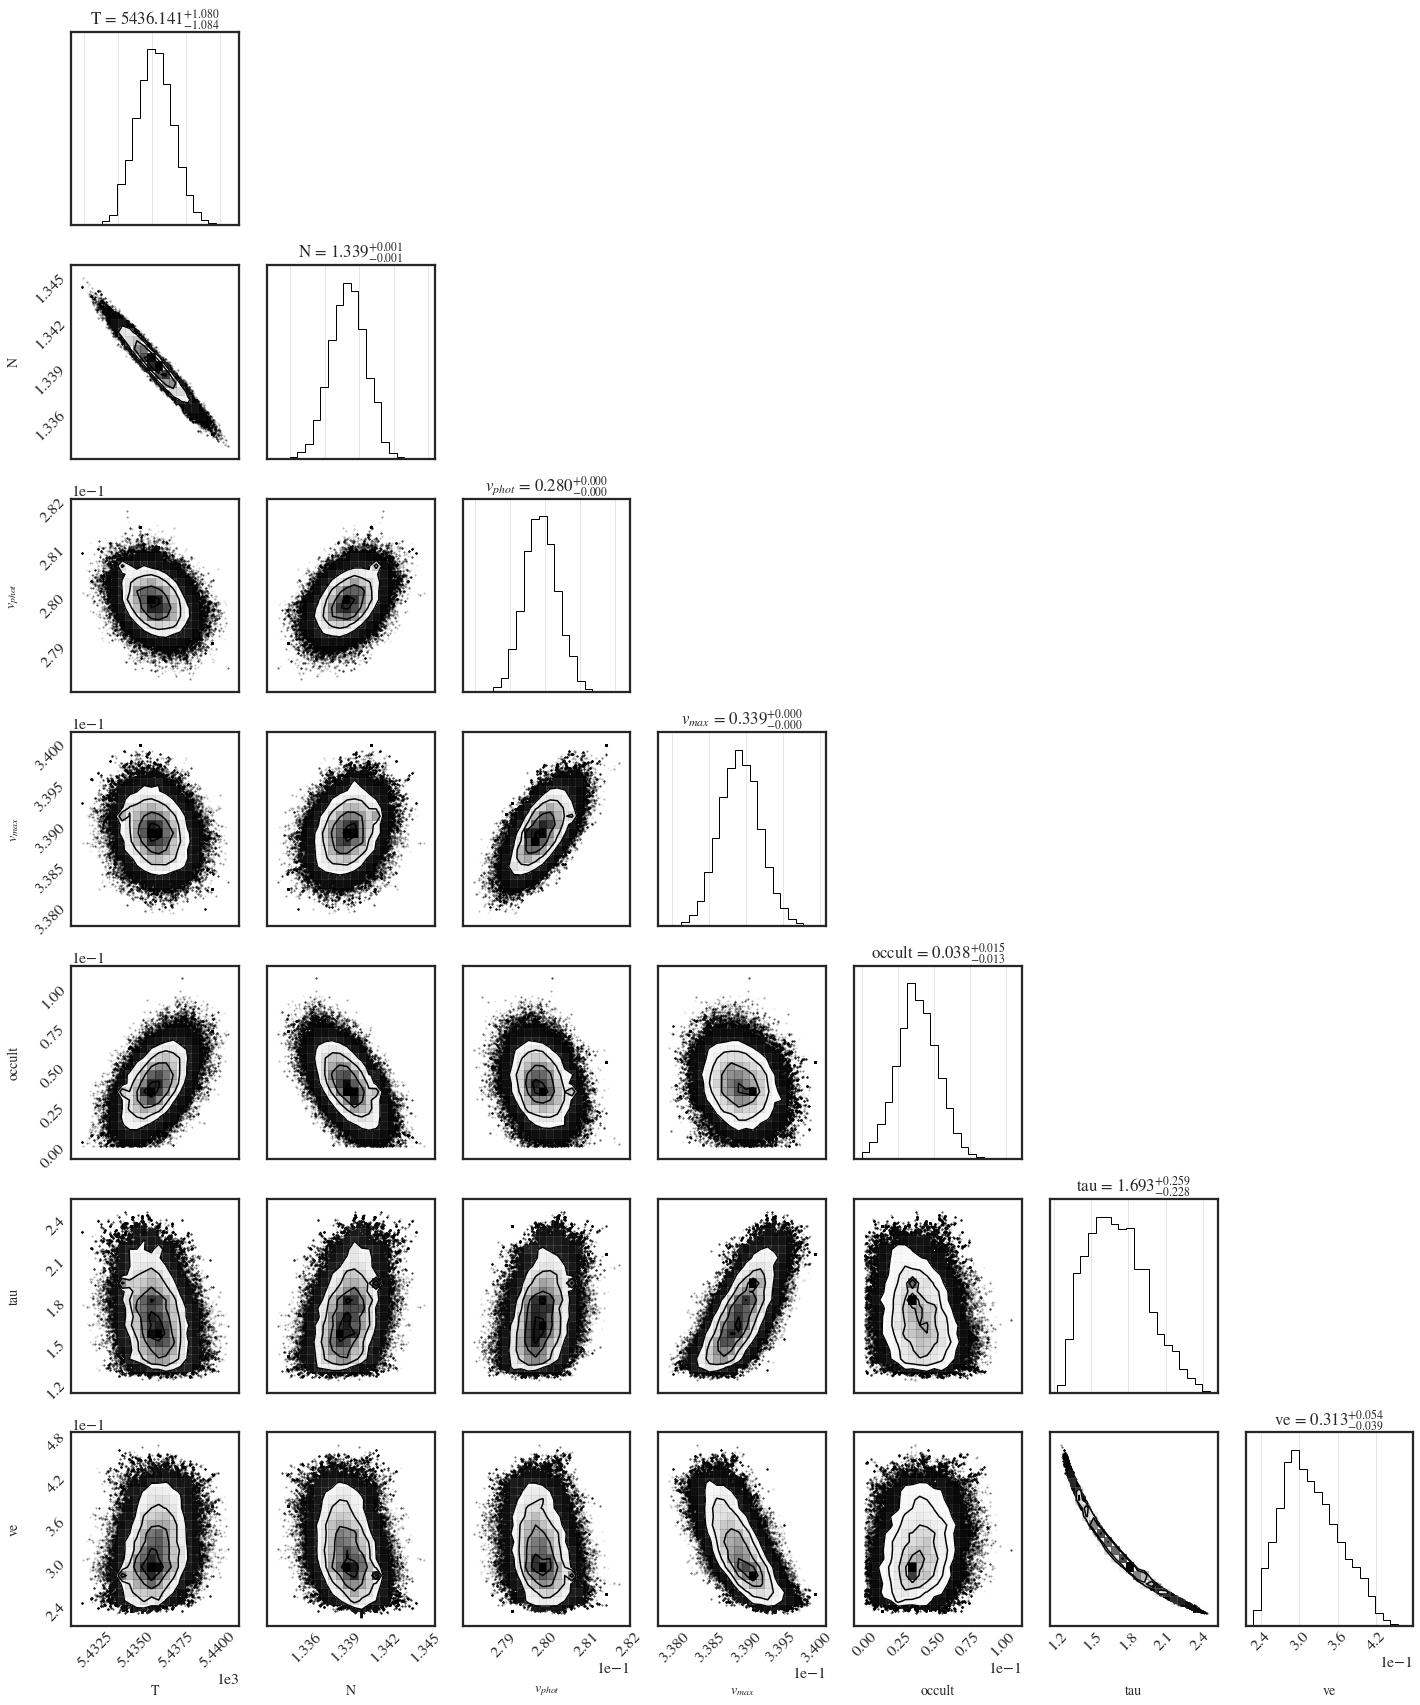

In [20]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

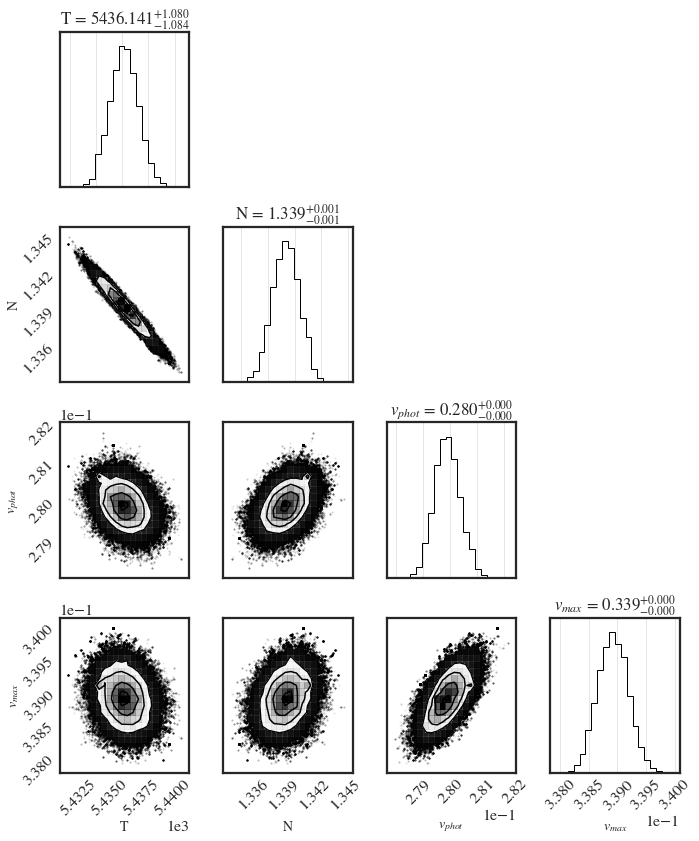

In [21]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_small_n.png', dpi=300)

In [60]:
## day 1
1+(23-12)/24+(21-41)/24/60

#23:45:35
#23:34:00
#23:22:22
#23:57:12
        
dtime1 = 1 + (23-12)/24 + (np.mean([16])-41)/(24*60)
dtime1

1.440972222222222

In [61]:
## day 2
2+(23-12)/24+(28-41)/24/60

# 23:53:42
# 23:58:38
# 23:38:35
# 23:28:45

dtime2 = 2 + (23-12)/24 + (np.mean([23])-41)/(24*60)
dtime2

2.4458333333333333

In [54]:
3+(24-12)/24+(5-41)/24/60

#  23:25:24
#  23:37:01
#  23:48:40
#  00:23:28
#  00:11

dtime3 = 3 + (23-12)/24 + (np.mean([25, 37, 48, 23+60, 11+60])-41)/(24*60)
dtime3

3.466527777777778

In [58]:
30/24/60

0.020833333333333332

In [62]:
3+(24-12)/24+(5-41)/24/60

#  23:50
#  23:25
#  23:30
#  23:35

dtime4 = 4 + (23-12)/24 + (np.mean([13])-41)/(24*60)
dtime4

4.438888888888888

In [31]:
## day 4
4+(23-12)/24+(50-41)/24/60

4.464583333333333

In [40]:
30/24/60

0.020833333333333332